# Использование клеточных автоматов для целей восстановления траектории движения облаков на спутниковых снимках

In [50]:
# Подключаем нужные библиотеки
import numpy as np
import scipy.spatial
import os

from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

Создаем матрицу, в которой пикселям, которые закрыты облаками, присвоено значение 0.

In [51]:
matrix = np.load('/media/mikhail/Data/LST/Inputs/20190519T080241.npy')

Посмотрим как выглядит матрица

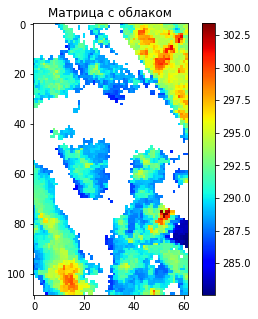

In [52]:
masked_array = np.ma.masked_where(matrix == -100.0, matrix)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='white')
plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
plt.title('Матрица с облаком')
plt.colorbar()
plt.show()

# Сохраним матрицу
masked_array = np.ma.masked_where(matrix == -100.0, matrix)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='white')
plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 284, vmax = 303)
plt.title('Начальная конфигурация')
plt.colorbar()
plt.savefig('/media/mikhail/Data/Графики/Cellular/Iter_0', dpi = 300)
plt.close()

Облако показано белым цветом. При этом на матрице видно ту область, на которую облако повлияло. Так, температура вокруг облака, несколько ниже, чем у остальных пикселей на снимке. 

Это происходит по двум причнам:
* Облако затеняет некоторые окрестные пиксели на снимке, из-за чего, даже если пиксель не помечен, как закрытый облаком, влияние облака на него очевидно
* Облако - объект не стационарный. Они постоянно движутся по какой-то траектории, из-за чего пиксели, которые в данный момент облаком не закрыты, были им закрыты несколько часов/минут назад. То есть, солнечная радиация да этих пикселей не доходила, поэтому их температура в момент съемки несколько ниже, чем могла бы быть в действительности.

## Первая реализация алгоритма - использование температуры окржения

В данной реализации при принятии решения будет ли данная ячейка отнесена к облаку или нет, мы используем температуру ближайших 15ти пикселей к данной ячейке. Если температура в данном пикселе меньше, чем средняя температура в 15-ти ближайших - 1 градус и при этом среди соседей для этого пикселя есть облако, то на следующем шаге он будет помечен как облако.

In [53]:
def step(matrix):
    # Копия матрицы, в которую будут добавляться пиксели
    next_matrix = np.copy(matrix)
    
    # Рассчет порога
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    minimum = np.min(masked_array)
    maximum = np.max(masked_array)
    # Порог - 20 процентов от амплитуды на данной сцене
    amplitide = maximum - minimum
    threshold = amplitide/20
    
    print('Пиксель не должен быть холоднее своего окружения более, чем на', threshold, 'градуса(ов)')
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Если пиксель расположен в верхней строке
            if i == 0:
                # Крайняя левая ячейка
                if j == 0:
                    # Урезанная окрестность Мура 
                    arr = matrix[i : i+2, j : j+2]
                # Крайняя правая ячейка
                elif j == (matrix.shape[1]-1):
                    arr = matrix[i : i+2, j-1 : j+1]
                # Весь остальной ряд
                else:
                    arr = matrix[i : i+2, j-1 : j+2]
            
            # Если пиксель расположен в левом столбце
            elif j == 0:
                # Крайняя нижняя ячейка
                if i == (matrix.shape[0]-1):
                    arr = matrix[i-1 : i+1, j : j+2]
                # Весь остальной ряд
                else:
                    arr = matrix[i-1 : i+2, j : j+2]
            
            # Если пиксель расположен в нижней строке 
            elif i == (matrix.shape[0]-1):
                # Крайняя правая ячейка
                if j == (matrix.shape[1]-1):
                    arr = matrix[i-1 : i+1, j-1 : j+1]
                # Весь остальной ряд
                else:
                    arr = matrix[i-1 : i+1, j-1 : j+2]
                
            # Если пиксель расположен в правом столбце
            elif j == (matrix.shape[1]-1):
                arr = matrix[i-1 : i+2, j-1 : j+1]
                
            # Если пиксель закрыт облаком
            elif matrix[i,j] == -100.0:
                arr = np.zeros((2,2))
            else:
                # Окрестность Мура для точки
                arr = matrix[i-1 : i+2, j-1 : j+2] 
    
            # Проверка, есть ли в окрестности облако
            id_cloud = np.argwhere(arr == -100.0)
            # Если есть и при этом сам пиксель не закрыт облаком
            # то сравниваем температуру пикселя со средней температурой окрестности
            if len(id_cloud) != 0 and matrix[i,j] != -100.0:
                # Берем только не закрытые облаком пиксели (все известные пиксели для данной матрицы)
                coords = np.argwhere(matrix != -100.0)              
                # Координаты пикселя, от которого мы рассчитываем расстояния
                target_pixel = np.array([[i, j]])
                # Вектор из рассчитаных расстояний от целевого пикселя до всех остальных
                distances = scipy.spatial.distance.cdist(target_pixel, coords)[0] 
                    
                # Выбираем ближайшие 10 пикселей
                new_coords = []
                for iter in range(0,10):
                    # Какой индекс в массиве coords имеет элемент с наименьшим расстоянием от целевого пикселя
                    index_min_dist = np.argmin(distances)

                    # Координата данного пикселя в матрице
                    new_coord = coords[index_min_dist]

                    # Добавляем координаты
                    new_coords.append(new_coord)

                    # Заменяем минимальный элемент из массива на очень большое число
                    distances[index_min_dist] = np.inf
                    
                # Записываем температуру этих ближайших 10 пикселей
                list_tmp = []
                for coord in new_coords:
                    list_tmp.append(matrix[coord[0], coord[1]])
                list_tmp = np.array(list_tmp)
                    
                # Берем среднее значение
                mean_local_tmp = np.mean(list_tmp)
                    
                # Если температура в пикселе ниже, чем средняя по окрестности - 3 градуса, то 
                # на следующем шаге он будет помечен как "облачный"
                if matrix[i,j] <= mean_local_tmp - threshold:
                    next_matrix[i,j] = -100.0
                    
    # Возвращаем матрицу, которая будет получена на следующем шаге
    return(next_matrix)

Запускаем алгоритм на 7 шагов.

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


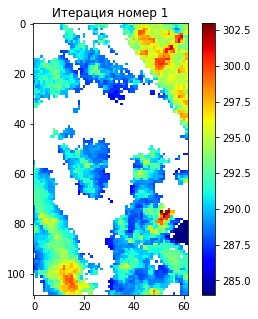

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


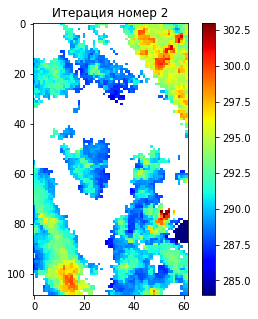

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


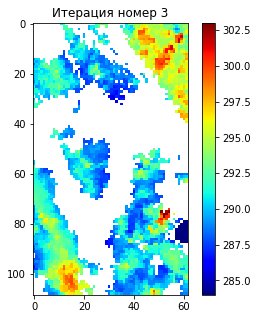

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


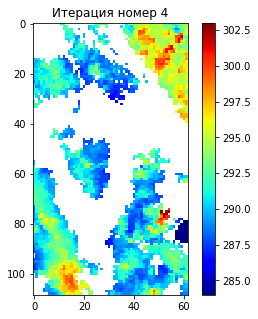

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


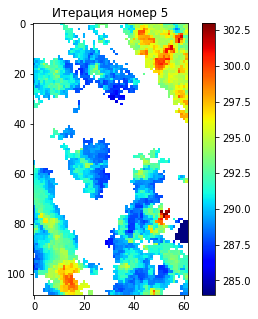

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


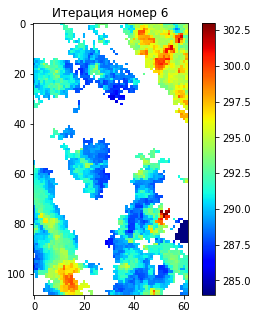

Пиксель не должен быть холоднее своего окружения более, чем на 1.0421005249023438 градуса(ов)


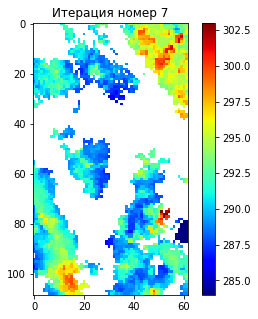

In [54]:
rcParams['figure.figsize'] = 5, 5
path = '/media/mikhail/Data/Графики/Cellular/Simple'
for iter in range(1, 8):
    matrix = step(matrix)
    name = 'Итерация номер ' + str(iter)
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='white')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 284, vmax = 303)
    plt.title(name)
    plt.colorbar()
    plt.show()
    
    # Сохраняем матрицу в файл
    save_name = 'Iter_' + str(iter)
    save_path = os.path.join(path, save_name)
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='white')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 284, vmax = 303)
    plt.title(name)
    plt.colorbar()
    plt.savefig(save_path, dpi = 300)
    plt.close()

Данная реализация одна из самых примитивных. В дальнейшем можно считать количество "облачных" пикселей рядом с рассматриваемым, и совместно с тем, насколько сильно температура ниже окрестной, делать переход в новое состояние вероятностным. Например, чем больше соседних пикселей закрыто облаком и чем ниже температура в рассматриваемом, тем ближе к 1 вероятность его перехода в состояние "облачного". 

Подобный подход можно применять и для других задач, где есть возможность отслеживать передвижение объекта, или сам объект, по низкому значению температуры на фоне относительно высоких значений в окрестностях.

Естественно, параметром может быть не только температура.

## Вторая реализация - использование внутренней структуры территории

В данной реализации мы исходим из предположения, что если пиксель принадлежит некоторому биому, и его температура ниже, чем средняя по биому, то он, скорее всего затенен.

In [55]:
def step(matrix, biome_matrix):
    # Матрице с биомами мы присваиваем значение пропуска в тех местах, где есть облака в данный момент
    biome_matrix[matrix == -100.0] = -100.0

    # Копия матрицы, в которую будут добавляться пиксели
    next_matrix = np.copy(matrix)
    
    # Рассчет порога
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    minimum = np.min(masked_array)
    maximum = np.max(masked_array)
    # Порог - 20 процентов от амплитуды на данной сцене
    amplitide = maximum - minimum
    threshold = amplitide/20
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Если пиксель расположен в верхней строке
            if i == 0:
                # Крайняя левая ячейка
                if j == 0:
                    # Урезанная окрестность Мура 
                    arr = matrix[i : i+2, j : j+2]
                # Крайняя правая ячейка
                elif j == (matrix.shape[1]-1):
                    arr = matrix[i : i+2, j-1 : j+1]
                # Весь остальной ряд
                else:
                    arr = matrix[i : i+2, j-1 : j+2]
            
            # Если пиксель расположен в левом столбце
            elif j == 0:
                # Крайняя нижняя ячейка
                if i == (matrix.shape[0]-1):
                    arr = matrix[i-1 : i+1, j : j+2]
                # Весь остальной ряд
                else:
                    arr = matrix[i-1 : i+2, j : j+2]
            
            # Если пиксель расположен в нижней строке 
            elif i == (matrix.shape[0]-1):
                # Крайняя правая ячейка
                if j == (matrix.shape[1]-1):
                    arr = matrix[i-1 : i+1, j-1 : j+1]
                # Весь остальной ряд
                else:
                    arr = matrix[i-1 : i+1, j-1 : j+2]
                
            # Если пиксель расположен в правом столбце
            elif j == (matrix.shape[1]-1):
                arr = matrix[i-1 : i+2, j-1 : j+1]
                
            # Если пиксель закрыт облаком
            elif matrix[i,j] == -100.0:
                arr = np.zeros((2,2))
            else:
                # Окрестность Мура для точки
                arr = matrix[i-1 : i+2, j-1 : j+2]
                   
    
            # Проверка, есть ли в окрестности облако
            id_cloud = np.argwhere(arr == -100.0)
            # Если есть и при этом сам пиксель не закрыт облаком
            # то сравниваем температуру пикселя со средней температурой окрестности
            if len(id_cloud) != 0 and matrix[i,j] != -100.0:
                
                # Код биома (группы пикселей) для ячейки
                biome_code = biome_matrix[i, j]  
                # Индексы точек, которые попадают в данный биом и при этом в данный момент не являются пропусками
                coords = np.argwhere(biome_matrix == biome_code)
                # Если точек в биоме недостаточно, то берем все известные точки
                if len(coords) < 16:
                    coords = np.argwhere(matrix != -100.0)
                else:
                    pass
            
                # Координаты пикселя, от которого мы рассчитываем расстояния
                target_pixel = np.array([[i, j]])
                # Вектор из рассчитаных расстояний от целевого пикселя до всех остальных
                distances = scipy.spatial.distance.cdist(target_pixel, coords)[0] 
                    
                # Выбираем ближайшие 15 пикселей
                new_coords = []
                for iter in range(0,15):
                    # Какой индекс в массиве coords имеет элемент с наименьшим расстоянием от целевого пикселя
                    index_min_dist = np.argmin(distances)

                    # Координата данного пикселя в матрице
                    new_coord = coords[index_min_dist]

                    # Добавляем координаты
                    new_coords.append(new_coord)

                    # Заменяем минимальный элемент из массива на очень большое число
                    distances[index_min_dist] = np.inf
                    
                # Записываем температуру этих ближайших 15 пикселей
                list_tmp = []
                for coord in new_coords:
                    list_tmp.append(matrix[coord[0], coord[1]])
                list_tmp = np.array(list_tmp)
                    
                # Берем медианное значение
                mean_local_tmp = np.median(list_tmp)
                    
                # Если температура в пикселе ниже, чем средняя по окрестности - 3 градуса, то 
                # на следующем шаге он будет помечен как "облачный"
                if matrix[i,j] <= mean_local_tmp - threshold:
                    next_matrix[i,j] = -100.0
                    
    # Возвращаем матрицу, которая будет получена на следующем шаге
    return(next_matrix)

Загружаем необходимые матрицы

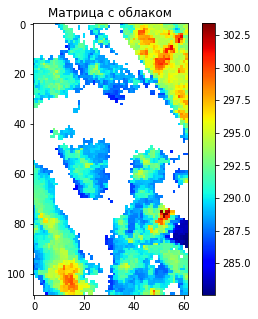

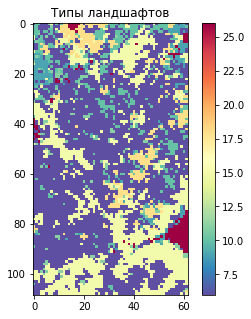

In [57]:
matrix = np.load('/media/mikhail/Data/LST/Inputs/20190519T080241.npy')
masked_array = np.ma.masked_where(matrix == -100.0, matrix)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='white')
plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
plt.title('Матрица с облаком')
plt.colorbar()
plt.show()

biome_matrix = np.load('/media/mikhail/Data/LST/Extra/Extra.npy')
plt.imshow(biome_matrix, interpolation='nearest', cmap ='Spectral_r')
plt.title('Типы ландшафтов')
plt.colorbar()
plt.show()

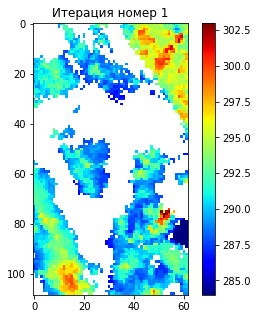

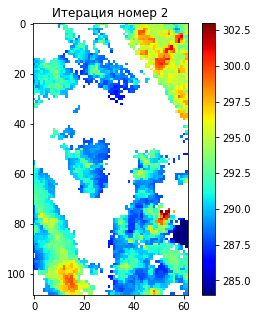

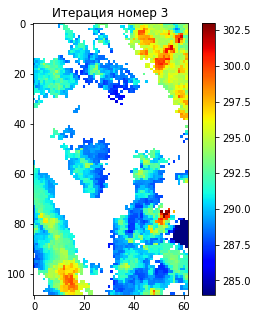

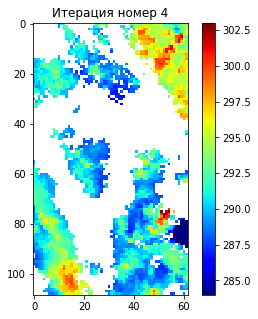

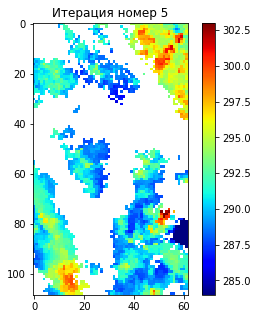

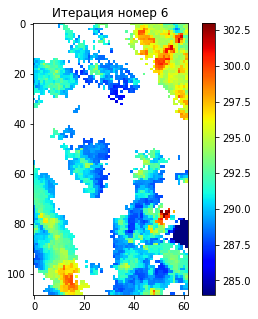

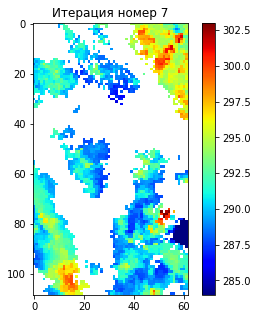

In [58]:
rcParams['figure.figsize'] = 5, 5
path = '/media/mikhail/Data/Графики/Cellular/Biome'
for iter in range(1, 8):
    matrix = step(matrix, biome_matrix)
    name = 'Итерация номер ' + str(iter)
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='white')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 284, vmax = 303)
    plt.title(name)
    plt.colorbar()
    plt.show()
    
    # Сохраняем матрицу в файл
    save_name = 'Iter_' + str(iter)
    save_path = os.path.join(path, save_name)
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='white')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 284, vmax = 303)
    plt.title(name)
    plt.colorbar()
    plt.savefig(save_path, dpi = 300)
    plt.close()